## Проект "Разработка модели оценивания стоимости автомобиля"

## Описание проекта:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

+ качество предсказания
+ скорость предсказания
+ время обучения

<b>Примечания:</b>

+ Для оценки качества моделей применяйте метрику RMSE.
+ Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
+ Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
+ Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
+ Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del: del features_train

## Описание данных:

Данные находятся в файле /datasets/autos.csv

<b>Признаки:</b> <div class="alert alert-success">
+ DateCrawled — дата скачивания анкеты из базы
+ VehicleType — тип автомобильного кузова
+ RegistrationYear — год регистрации автомобиля
+ Gearbox — тип коробки передач
+ Power — мощность (л. с.)
+ Model — модель автомобиля
+ Kilometer — пробег (км)
+ RegistrationMonth — месяц регистрации автомобиля
+ FuelType — тип топлива
+ Brand — марка автомобиля
+ Repaired — была машина в ремонте или нет
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя
</div>
<b>Целевой признак:</b>
+ <font color='green'> Price — цена (евро)</font> 

## План работы над проектом:

1. Загрузить данные и провести предобработку.
2. Выполнить сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрать лучшую модель по результатам метрики RMSE и времени обучения.
4. Оформить проект и написать выводы.

## 1. Подготовка данных

### 1.1 Просмотр данных

In [1]:
! pip install catboost

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print('Ok')

Ok


In [4]:
try:
    df = pd.read_csv(r'C:\Users\user\Desktop\Обучение\Data Science\Проекты ЯП по DS\10 Стоимость автомобиля\autos.csv')

except:
    print('Ошибка загрузки') 

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Создадим функии для просмотра данных таблицы:

In [6]:
# функция для вывода состава столбцов
def describe_cols(df_data):
    df = df_data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]
        
    return values.T.sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)


# функция для вывода пустых значений и их доли в столбцах датафрейма
def nan_values(df_data):
    df = df_data
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 1)
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing}).reset_index(drop = True)
    
    return missing_value_df


# функция для вывода информации о файле
def df_info (df_data):
    print('Количество строк файла:', len(df_data))
    print()
    print('Информация о содержимом файла:')
    display(describe_cols(df_data))
    print()
    print('Информация о пропусках данных:')
    display(nan_values(df_data))
    print()
    print('Первые пять строк таблицы:')
    display(df_data.head())

# просмотр данных столбца: уникальные значения, тип данных, кол-во пропусков
def preprocessing(df, column):
    print('\nУНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦА', column)
    #print(column, '-', dict_name[column])
    print('Тип данных', df[column].dtypes)
    print('Количество пропусков',df[column].isna().sum())
    print('Процент пропусков', round(df[column].isna().mean()*100, 2))
    if df[column].dtypes != 'object':
        print('Минимальное значение:',df[column].min(), 'Максимальное значение:', df[column].max())
    print('Уникальные значения:\n',df[column].value_counts(),'\n')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
df_info(df)

Количество строк файла: 354369

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Price,"[480, 18300, 9800, 1500, 3600, 650, 2200, 0, 1...",int64,3731
RegistrationYear,"[1993, 2011, 2004, 2001, 2008, 1995, 1980, 201...",int64,151
Power,"[0, 190, 163, 75, 69, 102, 109, 50, 125, 101, ...",int64,712
Kilometer,"[150000, 125000, 90000, 40000, 30000, 70000, 5...",int64,13
RegistrationMonth,"[0, 5, 8, 6, 7, 10, 12, 11, 2, 3, 1, 4, 9]",int64,13
NumberOfPictures,[0],int64,1
PostalCode,"[70435, 66954, 90480, 91074, 60437, 33775, 671...",int64,8143
DateCrawled,"[2016-03-24 11:52:17, 2016-03-24 10:58:45, 201...",object,271174
VehicleType,"[nan, coupe, suv, small, sedan, convertible, b...",object,8
Gearbox,"[manual, auto, nan]",object,2



Информация о пропусках данных:


,column_name,num_missing,percent_missing
0,DateCrawled,0,0.0
1,Price,0,0.0
2,VehicleType,37490,10.6
3,RegistrationYear,0,0.0
4,Gearbox,19833,5.6
5,Power,0,0.0
6,Model,19705,5.6
7,Kilometer,0,0.0
8,RegistrationMonth,0,0.0
9,FuelType,32895,9.3



Первые пять строк таблицы:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В некоторых столбцах есть пропуски, изучим уникальные данные в каждом столбце.

In [10]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column,':')
        print(data_frame[column].unique(), '\n')

In [11]:
show_rows(df)

Уникальные значения столбца DateCrawled :
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12'] 

Уникальные значения столбца Price :
[  480 18300  9800 ... 12395 18429 10985] 

Уникальные значения столбца VehicleType :
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Уникальные значения столбца RegistrationYear :
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 

['2016-03-24 00:00:00' '2016-03-14 00:00:00' '2016-03-17 00:00:00'
 '2016-03-31 00:00:00' '2016-04-04 00:00:00' '2016-04-01 00:00:00'
 '2016-03-21 00:00:00' '2016-03-26 00:00:00' '2016-04-07 00:00:00'
 '2016-03-15 00:00:00' '2016-03-11 00:00:00' '2016-03-20 00:00:00'
 '2016-03-23 00:00:00' '2016-03-27 00:00:00' '2016-03-12 00:00:00'
 '2016-03-13 00:00:00' '2016-03-18 00:00:00' '2016-03-10 00:00:00'
 '2016-03-07 00:00:00' '2016-03-09 00:00:00' '2016-03-08 00:00:00'
 '2016-04-03 00:00:00' '2016-03-29 00:00:00' '2016-03-25 00:00:00'
 '2016-03-28 00:00:00' '2016-03-30 00:00:00' '2016-03-22 00:00:00'
 '2016-02-09 00:00:00' '2016-03-05 00:00:00' '2016-04-02 00:00:00'
 '2016-03-16 00:00:00' '2016-03-19 00:00:00' '2016-04-05 00:00:00'
 '2016-03-06 00:00:00' '2016-02-12 00:00:00' '2016-03-03 00:00:00'
 '2016-03-01 00:00:00' '2016-03-04 00:00:00' '2016-04-06 00:00:00'
 '2016-02-15 00:00:00' '2016-02-24 00:00:00' '2016-02-27 00:00:00'
 '2015-03-20 00:00:00' '2016-02-28 00:00:00' '2016-02-17 00:00

+ В столбце RegistrationYear существуют некорректные значения года регистрации.
+ В столбце RegistrationMonth отсутсвует месяц регистрации.
+ В столбце Power присутвует некорректное значение мощности.

<b>Определим признаки, важные для модели.

In [12]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

<div class="alert alert-warning">
    
+ DateCrawled — дата скачивания анкеты из базы
+ VehicleType — тип автомобильного кузова
+ RegistrationYear — год регистрации автомобиля
+ Gearbox — тип коробки передач
+ Power — мощность (л. с.)
+ Model — модель автомобиля
+ Kilometer — пробег (км)
+ RegistrationMonth — месяц регистрации автомобиля
+ FuelType — тип топлива
+ Brand — марка автомобиля
+ Repaired — была машина в ремонте или нет
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя
</div>


<font color = 'blue'> К значимым признакам отнесем следующие столбцы: </font>
<div class="alert alert-success">
    
+ VehicleType. Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.
+ RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.
+ Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.
+ Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
+ Model. В купе с типом машины и брендом може влиять на популярность у покупателей.
+ Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
+ FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
+ Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
+ Repaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
    
<b>Остальные столбцы для модели не требуются, так как не влияют на стоимость.



### 1.2 Предобработка данных

In [13]:
df_filtered = df[['VehicleType', 
                  'RegistrationYear',
                  'Gearbox', 
                  'Power',
                  'Model',
                  'Kilometer',
                  'FuelType',
                  'Brand',
                  'Repaired',
                  'Price']].copy()

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


<b>Столбцы, требующие обработки:</b>

+ VehicleType. Восстановим пропущенные значения по популярному типу из столбца Brand.
+ RegistrationYear. Скоректируем на основе реальных значений в машинах.
+ Gearbox. Для всех NaN установим значение 'manual'.
+ Power. Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
+ Model. Для всех NaN установим значение 'unknown'.
+ FuelType. Восстановим пропущенные значения по популярному типу из столбца Brand.
+ Repaired. Для всех NaN установим значение 'yes'.



<b>Проверим наполнение целевого признака Price.

In [14]:
df_filtered['Price'].value_counts().reset_index()

,index,Price
0,0,10772
1,500,5670
2,1500,5394
3,1000,4649
4,1200,4594
...,...,...
3726,1368,1
3727,233,1
3728,11080,1
3729,16340,1


Видим, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

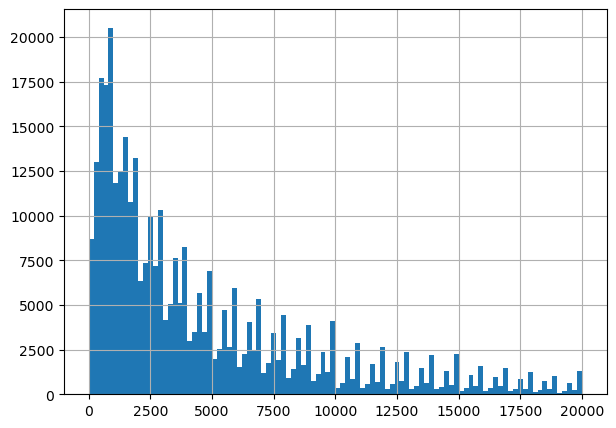

In [15]:
df_filtered = df_filtered.query('Price > 0')
df_filtered['Price'].hist(bins=100, figsize=(7,5))
df_filtered['Price'].describe()

Выделим квантили 5% и 80%

In [16]:
df_filtered['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64

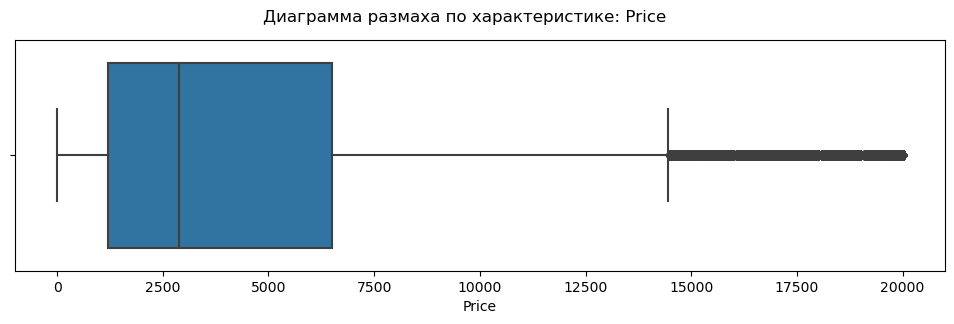

In [17]:
plt.figure(figsize=(12, 3))
sns.boxplot(x='Price', data=df_filtered)
plt.suptitle('Диаграмма размаха по характеристике: Price' )
plt.show();

In [18]:
def bound(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    print('Нижняя граница:', Q1)
    print('Верхняя граница:', Q3)
    print('Межквартильный размах:', IQR)
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    print(f'Граница выбросов для Price: ', round(lower_bound),'и', round(upper_bound))
            

In [19]:
bound(df_filtered, 'Price')

Нижняя граница: 1200.0
Верхняя граница: 6500.0
Межквартильный размах: 5300.0
Граница выбросов для Price:  -6750 и 14450


In [20]:
Q1 = df_filtered['Price'].quantile(0.025)
Q1

200.0

In [21]:
df_filtered[df_filtered['Price'] < 200 ]['Price'].count()

6690

<b>В качестве нижней границы возмем цену в 200 евро в качестве верхней 14 450 евро.

In [22]:
df_filtered = df_filtered.query('350 <= Price <= 7800')
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259798 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233267 non-null  object
 1   RegistrationYear  259798 non-null  int64 
 2   Gearbox           246646 non-null  object
 3   Power             259798 non-null  int64 
 4   Model             246358 non-null  object
 5   Kilometer         259798 non-null  int64 
 6   FuelType          236972 non-null  object
 7   Brand             259798 non-null  object
 8   Repaired          206998 non-null  object
 9   Price             259798 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


<b>Рассмотрим признаки требующие обработки:

<b> 1. RegistrationYear

count    259798.000000
mean       2002.844976
std          65.140145
min        1000.000000
25%        1999.000000
50%        2002.000000
75%        2006.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

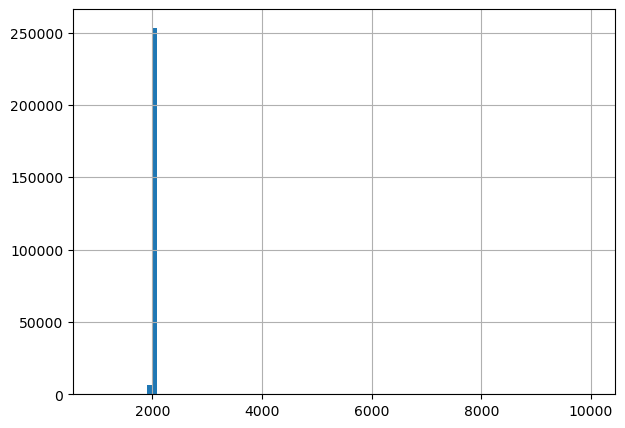

In [23]:
df_filtered['RegistrationYear'].hist(bins=100, figsize=(7,5))
df_filtered['RegistrationYear'].describe()

В годе регистрации наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.

In [24]:
date = pd.to_datetime(df['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

count    247788.000000
mean       2001.539179
std           6.112319
min        1910.000000
25%        1998.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

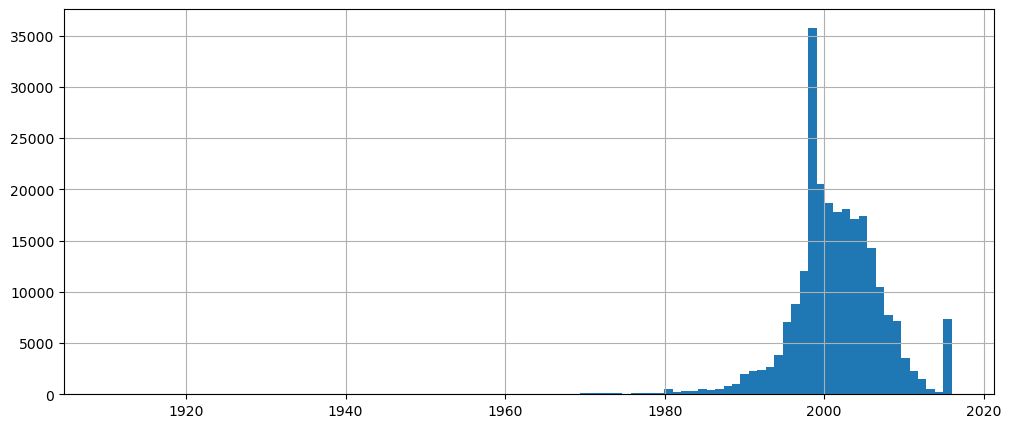

In [25]:
df_filtered = df_filtered.query('1899 < RegistrationYear < 2017')
df_filtered['RegistrationYear'].hist(bins=100, figsize=(12,5))
df_filtered['RegistrationYear'].describe()

In [26]:
bound(df_filtered, 'RegistrationYear')

Нижняя граница: 1998.0
Верхняя граница: 2005.0
Межквартильный размах: 7.0
Граница выбросов для Price:  1988 и 2016


count    243333.000000
mean       2001.954096
std           5.184856
min        1988.000000
25%        1999.000000
50%        2002.000000
75%        2005.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

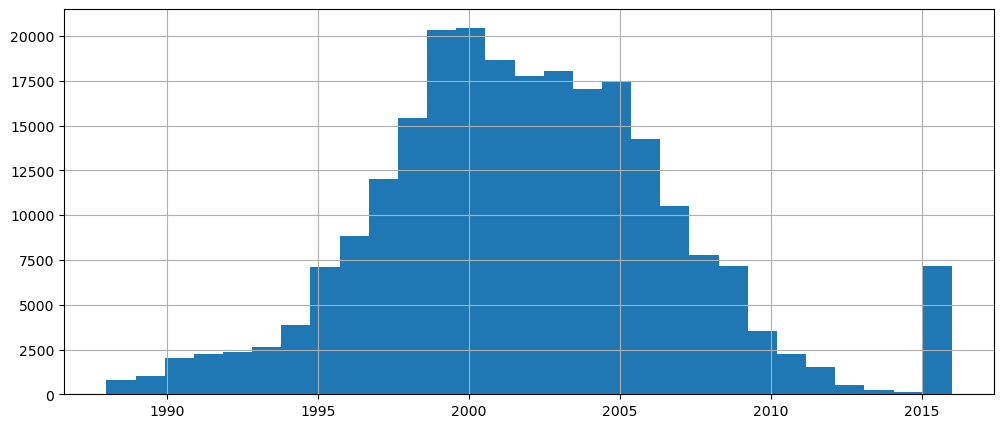

In [27]:
df_filtered = df_filtered.query('1987 < RegistrationYear < 2017')
df_filtered['RegistrationYear'].hist(bins=len(range(1988,2017)), figsize=(12,5))
df_filtered['RegistrationYear'].describe()

<b>2. Проведем замену NaN в Gearbox, Repaired и Model.

In [28]:
df_filtered.fillna({'Gearbox':'manual', 
                    'Repaired':'yes',
                    'Model':'unknown'},
                    inplace=True)

df_filtered.isna().mean()

VehicleType         0.057769
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.072033
Brand               0.000000
Repaired            0.000000
Price               0.000000
dtype: float64

<b> 3. VehicleType - оценим количество пропущенных значений относительно всех значений в столбце 

In [29]:
print(df_filtered['VehicleType'].value_counts())
df_filtered['VehicleType'].isna().sum()

small          65990
sedan          65946
wagon          47096
bus            20873
convertible    12277
coupe           9737
suv             5061
other           2296
Name: VehicleType, dtype: int64


14057

Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

In [30]:
vehicle_type_pivot_table = df_filtered.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)

df_filtered[df_filtered['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      92.0    369.0  1035.0   15.0   
convertible      105.0   667.0   1605.0       6.0    194.0    85.0    NaN   
coupe            173.0   629.0   2523.0      29.0     15.0   136.0    NaN   
other             10.0    80.0    186.0      13.0      6.0    92.0    5.0   
sedan            772.0  7636.0  11171.0     143.0    199.0   519.0   97.0   
small            182.0   931.0    323.0     574.0     12.0  1360.0  178.0   
suv                NaN    14.0    189.0     130.0     12.0     8.0   46.0   
wagon            388.0  6414.0   4994.0      80.0    183.0   489.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   701.0  ...   485.0   158.0     1.0   
convertible    1.0      8.0   238.0  ...     NaN     2.0   988.0   
coupe          2.0      NaN   143.0  ...    63.0     NaN   318.0   
other          5.0      9.0   145.0  ...    47.0    21.0     8.0   
sedan         87.0     35.0   778.0  ...  1220.0   687.0    26.0   
small        247.0    438.0  4435.0  ...  2620.0   930.0  3099.0   
suv            1.0     45.0    17.0  ...     1.0     7.0     NaN   
wagon         36.0     16.0   370.0  ...   215.0  1763.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  124.0   16.0   26.0   340.0     NaN     5802.0     NaN  
convertible          104.0    NaN   30.0    45.0    10.0     1846.0    34.0  
coupe                 34.0    3.0    4.0   171.0     1.0      673.0    38.0  
other                135.0    4.0    7.0    14.0     1.0      534.0     NaN  
sedan                178.0   97.0  131.0   732.0    71.0    14605.0   458.0  
small                139.0   99.0  809.0  1472.0    24.0    15066.0     3.0  
suv                  138.0   42.0  523.0   243.0     NaN      231.0    29.0  
wagon                 85.0  239.0   83.0   449.0    30.0     9674.0  1647.0  

[8 rows x 40 columns]

sedan          772
wagon          388
small          182
coupe          173
convertible    105
other           10
Name: VehicleType, dtype: int64

In [31]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,4.0,92.0,369.0,1035.0,15.0,26.0,31.0,701.0,...,485.0,158.0,1.0,124.0,16.0,26.0,340.0,NaN,5802.0,NaN
convertible,105.0,667.0,1605.0,6.0,194.0,85.0,NaN,1.0,8.0,238.0,...,NaN,2.0,988.0,104.0,NaN,30.0,45.0,10.0,1846.0,34.0
coupe,173.0,629.0,2523.0,29.0,15.0,136.0,NaN,2.0,NaN,143.0,...,63.0,NaN,318.0,34.0,3.0,4.0,171.0,1.0,673.0,38.0
other,10.0,80.0,186.0,13.0,6.0,92.0,5.0,5.0,9.0,145.0,...,47.0,21.0,8.0,135.0,4.0,7.0,14.0,1.0,534.0,NaN
sedan,772.0,7636.0,11171.0,143.0,199.0,519.0,97.0,87.0,35.0,778.0,...,1220.0,687.0,26.0,178.0,97.0,131.0,732.0,71.0,14605.0,458.0
small,182.0,931.0,323.0,574.0,12.0,1360.0,178.0,247.0,438.0,4435.0,...,2620.0,930.0,3099.0,139.0,99.0,809.0,1472.0,24.0,15066.0,3.0
suv,NaN,14.0,189.0,130.0,12.0,8.0,46.0,1.0,45.0,17.0,...,1.0,7.0,NaN,138.0,42.0,523.0,243.0,NaN,231.0,29.0
wagon,388.0,6414.0,4994.0,80.0,183.0,489.0,227.0,36.0,16.0,370.0,...,215.0,1763.0,9.0,85.0,239.0,83.0,449.0,30.0,9674.0,1647.0


In [32]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243333 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       229276 non-null  object
 1   RegistrationYear  243333 non-null  int64 
 2   Gearbox           243333 non-null  object
 3   Power             243333 non-null  int64 
 4   Model             243333 non-null  object
 5   Kilometer         243333 non-null  int64 
 6   FuelType          225805 non-null  object
 7   Brand             243333 non-null  object
 8   Repaired          243333 non-null  object
 9   Price             243333 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.4+ MB


In [33]:
def fillna_by_brand(row):
    brand = row['Brand']
    fill_value = row['VehicleType']
    if row['VehicleType'] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

In [34]:
df_filtered.fillna({'VehicleType':0},inplace=True)
df_filtered['VehicleType'].isna().sum()

0

In [35]:
df_filtered

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
0,0,1993,manual,0,golf,150000,petrol,volkswagen,yes,480
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,650
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
...,...,...,...,...,...,...,...,...,...,...
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes,3200
354363,bus,2000,manual,0,zafira,150000,petrol,opel,no,1150
354365,0,2005,manual,0,unknown,20000,NaN,sonstige_autos,yes,2200
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,1199


In [36]:
df_filtered['VehicleType'] = df_filtered.apply(fillna_by_brand, axis=1)

In [37]:
df_filtered['VehicleType'].value_counts()


small          75777
sedan          69862
wagon          47343
bus            20930
convertible    12284
coupe           9737
suv             5104
other           2296
Name: VehicleType, dtype: int64

In [38]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243333 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       243333 non-null  object
 1   RegistrationYear  243333 non-null  int64 
 2   Gearbox           243333 non-null  object
 3   Power             243333 non-null  int64 
 4   Model             243333 non-null  object
 5   Kilometer         243333 non-null  int64 
 6   FuelType          225805 non-null  object
 7   Brand             243333 non-null  object
 8   Repaired          243333 non-null  object
 9   Price             243333 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.4+ MB


<b> 4. FuelType  - по похожему принципу

In [39]:
df_filtered['FuelType'].value_counts()
fuel_type_pivot_table = df_filtered.pivot_table(index=['FuelType'], 
                                                columns=['Brand'],
                                                values=['Price'],
                                                aggfunc=['count'])

fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,5.0,4.0,NaN,7.0,2.0,NaN,NaN,63.0,...,NaN,4.0,2.0,NaN,2.0,NaN,NaN,NaN,125.0,14.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,16.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,480.0,6497.0,5060.0,58.0,264.0,1177.0,98.0,1.0,4.0,1241.0,...,1229.0,1145.0,807.0,286.0,10.0,145.0,673.0,1.0,16496.0,579.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,NaN,NaN,NaN,35.0,NaN,5.0,NaN
lpg,30.0,356.0,604.0,137.0,77.0,63.0,35.0,23.0,5.0,63.0,...,56.0,48.0,3.0,55.0,25.0,18.0,18.0,NaN,452.0,96.0
other,NaN,NaN,4.0,NaN,NaN,2.0,NaN,1.0,NaN,2.0,...,NaN,NaN,1.0,8.0,NaN,1.0,NaN,17.0,12.0,2.0
petrol,1105.0,9255.0,14758.0,848.0,632.0,2444.0,424.0,374.0,562.0,5372.0,...,3332.0,2319.0,3604.0,537.0,449.0,1420.0,2716.0,105.0,31071.0,1460.0


In [40]:
df_filtered.fillna({'FuelType':0},inplace=True)
display(df_filtered['FuelType'].isna().sum())

0

In [41]:
def fillna_by_brand(row):
    brand = row['Brand']
    fill_value = row['FuelType']
    if row['FuelType'] == 0:
        fill_value = fuel_type_pivot_table[brand].idxmax()
    return fill_value

In [42]:
df_filtered['FuelType'].value_counts()

petrol      159720
gasoline     61226
0            17528
lpg           4206
cng            429
other           87
hybrid          83
electric        54
Name: FuelType, dtype: int64

In [43]:
df_filtered.isna().mean()

VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
Price               0.0
dtype: float64

<b>5. Power - рассмотрим некорректные значения.

count    243333.000000
mean        102.543617
std         180.694471
min           0.000000
25%          68.000000
50%         101.000000
75%         131.000000
max       20000.000000
Name: Power, dtype: float64

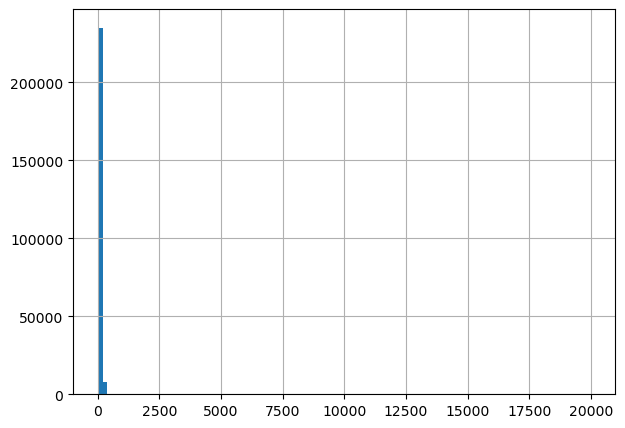

In [44]:
df_filtered['Power'].hist(bins=100, figsize=(7,5))
df_filtered['Power'].describe()

Раброс очень сильный, усечем выбросы больше 1000 л.с.

count    243122.000000
mean         99.219556
std          54.521057
min           0.000000
25%          68.000000
50%         101.000000
75%         131.000000
max        1000.000000
Name: Power, dtype: float64

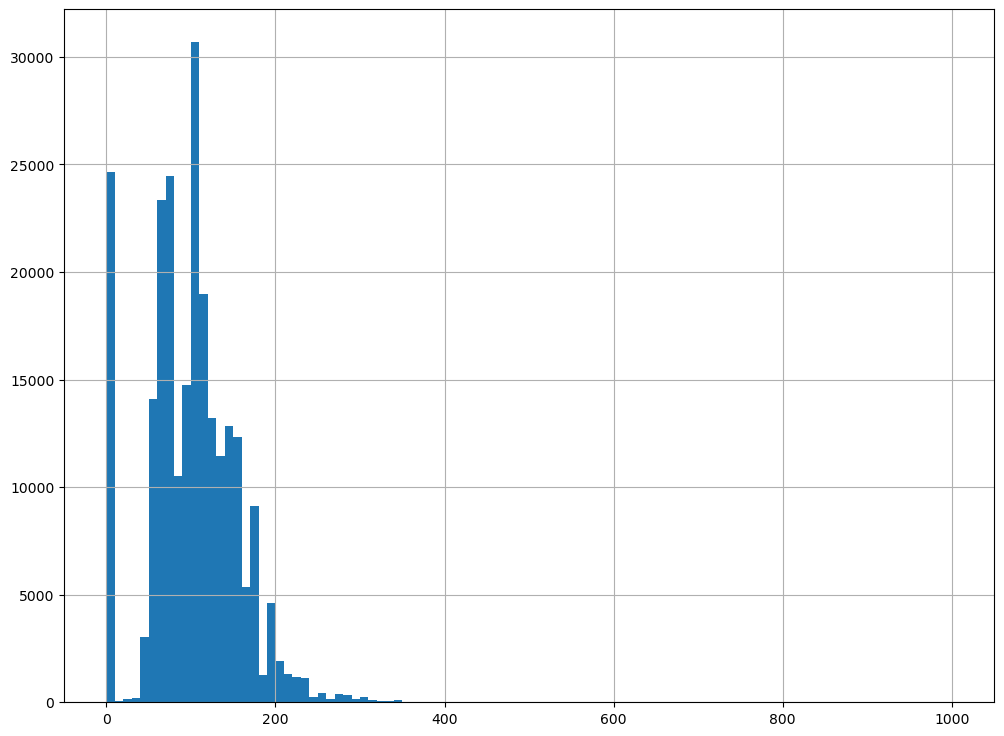

In [45]:
df_filtered = df_filtered.query('Power < 1001')
df_filtered['Power'].hist(bins=100, figsize=(12,9))
df_filtered['Power'].describe()

Из графика видно, что многие машины имеют мощность меньше 20. Эти строки не подлежат восстановлению и будут удалены. По правому отсечению выбреме границу в 400 л.с.

count    218197.000000
mean        110.132147
std          43.826618
min          26.000000
25%          75.000000
50%         104.000000
75%         136.000000
max         349.000000
Name: Power, dtype: float64

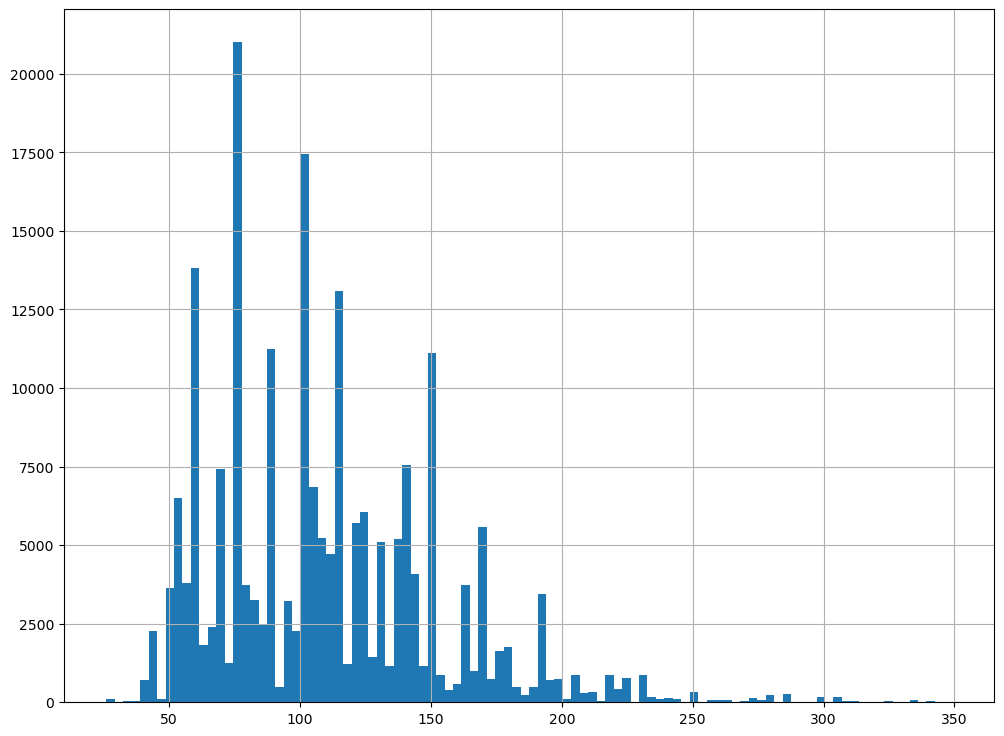

In [46]:
df_good = df_filtered.query('25 < Power < 350')
df_good['Power'].hist(bins=100, figsize=(12,9))
df_good['Power'].describe()

In [47]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218197 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       218197 non-null  object
 1   RegistrationYear  218197 non-null  int64 
 2   Gearbox           218197 non-null  object
 3   Power             218197 non-null  int64 
 4   Model             218197 non-null  object
 5   Kilometer         218197 non-null  int64 
 6   FuelType          218197 non-null  object
 7   Brand             218197 non-null  object
 8   Repaired          218197 non-null  object
 9   Price             218197 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.3+ MB


<b> 6. Фичи Gearbox и Repaired  - проведем замену столбцов на булев тип.

In [48]:
df_good

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no,3600
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,650
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
9,small,1998,manual,101,golf,150000,0,volkswagen,yes,999
...,...,...,...,...,...,...,...,...,...,...
354358,small,1998,manual,50,lupo,150000,petrol,volkswagen,no,1490
354361,sedan,2016,auto,150,159,150000,0,alfa_romeo,no,5250
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes,3200
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,1199


+ IsManualGearbox - 1(manual) - означает механическую коробку передач, 0(auto) - автоматическую.
+ IsRepaired - 1(yes) - означает машину c ремонтом, 0(no) - без ремонта.

In [49]:
df_good['IsManualGearbox'] = 0
df_good.loc[df_good['Gearbox'] == 'manual', 'IsManualGearbox'] = 1

display(df_good['IsManualGearbox'].value_counts())
df_good['Gearbox'].value_counts()

1    184056
0     34141
Name: IsManualGearbox, dtype: int64

manual    184056
auto       34141
Name: Gearbox, dtype: int64

In [50]:
df_good['IsRepaired'] = 0
df_good.loc[df_good['Repaired'] == 'yes', 'IsRepaired'] = 1
display(df_good['IsRepaired'].value_counts())
df_good['Repaired'].value_counts()

0    160998
1     57199
Name: IsRepaired, dtype: int64

no     160998
yes     57199
Name: Repaired, dtype: int64

Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом.

In [51]:
df_good.drop(['Repaired','Gearbox'], inplace=True, axis=1)
df_good['IsRepaired'] = pd.to_numeric(df_good['IsRepaired'], downcast='integer')
df_good['IsManualGearbox'] = pd.to_numeric(df_good['IsManualGearbox'], downcast='integer')
df_good['RegistrationYear'] = pd.to_numeric(df_good['RegistrationYear'], downcast='integer')
df_good['Power'] = pd.to_numeric(df_good['Power'], downcast='integer')
df_good['Kilometer'] = pd.to_numeric(df_good['Kilometer'], downcast='integer')
df_good['Price'] = pd.to_numeric(df_good['Price'], downcast='integer')
df_good.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218197 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       218197 non-null  object
 1   RegistrationYear  218197 non-null  int16 
 2   Power             218197 non-null  int16 
 3   Model             218197 non-null  object
 4   Kilometer         218197 non-null  int32 
 5   FuelType          218197 non-null  object
 6   Brand             218197 non-null  object
 7   Price             218197 non-null  int16 
 8   IsManualGearbox   218197 non-null  int8  
 9   IsRepaired        218197 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 10.8+ MB


In [52]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.8/43.3))

Уменьшение использования памяти на 75.06%


## Вывод по разделу 1

1. Была изучена таблица данных.
2. Выведены аномальные и пропущенные значения.
3. Отобраны небходимые столбцы для обучения модели.
4. Заполнены пропуски в столбцах и удалены некорректные значения.
5. Заменены два категориальных признака на численные.
6. Выигрыш в памяти составляет 75%, что ускорит обращение к памяти при обучении модели.

## 2. Обучение моделей

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. Ridge
3. DecisionTreeRegressor
4. CatBoostRegressor
5. LGBMRegressor

В качестве метрики для всех моделей будем использовать MSE и в финальной таблице переведем в RMSE. Качество моделей будем проверять на кроссвалидации.

Подготовим три типа признаков для кроссвалидации:

+ Неизмененные. Название original_features.
+ Закодированные методом OHE. Название ohe_features.
+ Закодированные методом OE. Название ordinal_features.

In [53]:
df_good.head()

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,Price,IsManualGearbox,IsRepaired
3,small,2001,75,golf,150000,petrol,volkswagen,1500,1,0
4,small,2008,69,fabia,90000,gasoline,skoda,3600,1,0
5,sedan,1995,102,3er,150000,petrol,bmw,650,1,1
6,convertible,2004,109,2_reihe,150000,petrol,peugeot,2200,1,0
9,small,1998,101,golf,150000,0,volkswagen,999,1,1


In [54]:
#Неизмененные принаки
original_features = df_good.drop('Price', axis=1)

#Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = cat_features.astype(str) #без этого выдает ошибку!
cat_features = pd.DataFrame(encoder.fit_transform(cat_features), index=df_good.index, columns=cat_columns)

ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

#Целевой признак
target = df_good['Price']


In [55]:
ordinal_features

,VehicleType,RegistrationYear,Power,Model,Kilometer,FuelType,Brand,IsManualGearbox,IsRepaired
3,5.0,2001,75,115.0,150000,7.0,38.0,1,0
4,5.0,2008,69,101.0,90000,3.0,31.0,1,0
5,4.0,1995,102,11.0,150000,7.0,2.0,1,1
6,1.0,2004,109,8.0,150000,7.0,25.0,1,0
9,5.0,1998,101,115.0,150000,0.0,38.0,1,1
...,...,...,...,...,...,...,...,...,...
354358,5.0,1998,50,142.0,150000,7.0,38.0,1,0
354361,4.0,2016,150,4.0,150000,0.0,0.0,0,0
354362,4.0,2004,225,139.0,150000,7.0,30.0,1,1
354366,1.0,2000,101,106.0,125000,7.0,32.0,0,0


In [56]:
ohe_features

,RegistrationYear,Power,Kilometer,IsManualGearbox,IsRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
3,2001,75,150000,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2008,69,90000,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,1995,102,150000,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,2004,109,150000,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1998,101,150000,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,1998,50,150000,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
354361,2016,150,150000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
354362,2004,225,150000,1,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
354366,2000,101,125000,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [57]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=42)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

### 2.1 Линейная регрессия

In [58]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 1271.8740478017833
Wall time: 7.9 s


In [59]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 1674386588535.9028
Wall time: 11.1 s


Масштабирование признаков ухудшает модель. Откажемся от применение масштаба.

### 2.2 Регрессия Ridge

In [60]:
%%time

regressor = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_R = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'solver': 'svd'}

Grid scores on development set:

1271.858787 for {'solver': 'auto'}
1271.858787 for {'solver': 'svd'}
1271.858787 for {'solver': 'cholesky'}
1961.397962 for {'solver': 'lsqr'}
1764.712390 for {'solver': 'sparse_cg'}

Wall time: 29.6 s


### 2.3 Регрессия DecisionTreeRegressor

Проведем два эксперимента.

1. Проверим модель на признаках, закодированных по методу OHE.
2. На признаках, закодированных по методу OE.

In [61]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[42]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 16, 'random_state': 19072020}

Grid scores on development set:

1535.834226 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 19072020}
1448.106577 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 19072020}
1350.712856 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 19072020}
1279.177877 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 19072020}
1227.789376 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 19072020}
1187.508911 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 19072020}
1151.532353 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 19072020}
1121.416779 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 19072020}
1096.548012 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 19072020}
1077.459031 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 19072020}
1061.656

In [62]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[42]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 13, 'random_state': 42}

Grid scores on development set:

1535.834226 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 42}
1448.220978 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 42}
1348.661717 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 42}
1278.195407 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 42}
1229.769375 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 42}
1185.371735 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 42}
1143.899823 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 42}
1112.116256 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 42}
1084.900169 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 42}
1064.535578 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 42}
1051.337500 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 42}


Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

### 2.4 Регрессия CatBoostRegressor


Проведем два эксперимента.

1. Обучим модель на данных, закодированных по методу OE.
2. Обучим на оригинальных данных с указанием категорий.

In [66]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[42],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 42, 'verbose': False}

Grid scores on development set:

919.631392 for {'learning_rate': 0.1, 'random_state': 42, 'verbose': False}
909.498426 for {'learning_rate': 0.5, 'random_state': 42, 'verbose': False}
924.305618 for {'learning_rate': 0.8, 'random_state': 42, 'verbose': False}

Wall time: 2min 45s


In [64]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=42, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 927.7267766357141
Wall time: 53 s


### 2.5 Регрессия LGBMRegressor

In [65]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 130917, number of used features: 9
[LightGBM] [Info] Start training from score 2889.821268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 130917, number of used features: 9
[LightGBM] [Info] Start training from score 2884.727415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003074 seconds.
You can set `force_row_wi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 130917, number of used features: 9
[LightGBM] [Info] Start training from score 2889.821268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 130917, number of used features: 9
[LightGBM] [Info] Start training from score 2884.727415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 130917, number of used features: 9
[LightGBM] [Info] Start training from score 2884.727415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 527
[LightGBM] [Info] Number of data points in the train set: 130918, number of used features: 9
[LightGBM] [Info] Start training from score 2887.603492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

## Вывод по разделу 2

Были изучены 5 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.

## 3. Анализ моделей

Проведем обучение на каждой модели с лучшими гиперпараметрами.

### 3.1 Линейная регрессия

In [74]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

Wall time: 1.7 s


LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 69.8 ms


In [76]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

In [77]:
final_RMSE_LR

1269.3145188525948

### 3.2 Регрессия Ridge

In [78]:
%%time

model = Ridge(solver='svd')
model.fit(ohe_features_train, target_train)

Wall time: 2.83 s


Ridge(solver='svd')

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)

In [79]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 75.3 ms


In [81]:
final_RMSE_R = mean_squared_error(target_test, target_predict) ** 0.5

In [82]:
final_RMSE_R

1269.5079248961972

### 3.3 Регрессия DecisionTreeRegressor

In [84]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=42) 
model.fit(ohe_features_train, target_train)

Wall time: 3.27 s


DecisionTreeRegressor(criterion='mse', max_depth=15, random_state=42)

DecisionTreeRegressor(

                       criterion='mse', max_depth=15, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=42, splitter='best')

In [85]:
%%time

target_predict = model.predict(ohe_features_test)

Wall time: 55.7 ms


In [86]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5             

In [90]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=42) 
model.fit(ordinal_features_train, target_train)

Wall time: 248 ms


DecisionTreeRegressor(criterion='mse', max_depth=13, random_state=42)

DecisionTreeRegressor( 

                      criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,                      
                      min_impurity_split=None, min_samples_leaf=1, 
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [89]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 12.5 ms


In [91]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5  

In [92]:
final_RMSE_DTR_ohe, final_RMSE_DTR_ordinal

(1024.3526654718532, 1037.5094694874444)

### 3.4 Регрессия CatBoostRegressor

In [95]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=42, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

Wall time: 12.7 s


In [96]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 12.8 ms


In [97]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

In [98]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=42, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

Wall time: 11.9 s


In [99]:
%%time

target_predict = model.predict(original_features_test)

Wall time: 78.9 ms


In [100]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

In [101]:
final_RMSE_CBR_ordinal, final_RMSE_CBR_original

(905.4202162458025, 924.0176084570741)

### 3.5 Регрессия LGBMRegressor

In [102]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=42)
model.fit(ordinal_features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 163647, number of used features: 9
[LightGBM] [Info] Start training from score 2888.844935
Wall time: 548 ms


LGBMRegressor(num_leaves=200, random_state=42)

LGBMRegressor(

              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=200, objective=None,
              random_state=19072020, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [103]:
%%time

target_predict = model.predict(ordinal_features_test)

Wall time: 107 ms


In [104]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [105]:
final_RMSE_LGBMR

906.1402710314001

### 3.6 Сравнение моделей

In [106]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_R,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[79,
                                     125,
                                     285,
                                     32,
                                     989,
                                     376,
                                     249],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_R,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[18.1,
                                      31.5,
                                      4.83,
                                      0.479,
                                      126,
                                      89,
                                      14.7],
        'Время предсказания модели, сек':[0.194,
                                          0.103,
                                          0.110,
                                          0.013,
                                          0.066,
                                          0.303,
                                          1.19]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,1271.874048,79,1269.314519,18.100,0.194,0.713120,0.026464,0.067010,0.806595
Ridge,1271.858787,125,1269.507925,31.500,0.103,0.713129,0.015206,0.126214,0.854549
DecisionTreeRegressor on OHE features,1040.307033,285,1024.352665,4.830,0.110,0.871857,0.099172,0.118182,1.089211
DecisionTreeRegressor on OE features,1048.362630,32,1037.509469,0.479,0.013,0.865158,1.000000,1.000000,2.865158
CatBoostRegressor on OE features,909.498426,989,905.420216,126.000,0.066,0.997252,0.003802,0.196970,1.198024
CatBoostRegressor on original features,927.726777,376,924.017608,89.000,0.303,0.977658,0.005382,0.042904,1.025944
LGBMRegressor,906.999340,249,906.140271,14.700,1.190,1.000000,0.032585,0.010924,1.043509


## Итоговый вывод

В ходе работы было выполнено:

1. Загружены данные и проведена предобработка.
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.
Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минмальным временем или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению. Считаем, что все параметры равноценны.

На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.

1. Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.

2. Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и DecisionTreeRegressor занимает третье место.

3. LinearRegression и Ridge показали себя на этой задачи очень слабо.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.

+ Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.
+ Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.
+ Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.